In [1]:
#controlled modular multiplcation: https://arxiv.org/abs/quant-ph/0205095
#medium post: https://medium.com/mit-6-s089-intro-to-quantum-computing/a-general-implementation-of-shors-algorithm-da1595694430
#draper paper: https://arxiv.org/pdf/quant-ph/0008033.pdf

In [1]:
# Note: This can be any hub/group/project that has access to the required device and the Qiskit runtime.
hub = "ibm-q"
group = "open"
project = "main"
backend_name = "ibm_brisbane"
hgp = f"{hub}/{group}/{project}"

In [3]:
#fetch api_key
with open("api_key.txt","r") as f:
    api_key = f.read()

In [4]:
import qiskit
from qiskit_ibm_provider import IBMProvider

# Save token if necessary
IBMProvider.save_account(overwrite=True,token=api_key)

# Get our backend
provider = IBMProvider()
available_backends = provider.backends()
backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using backend {backend.name}")

/var/folders/tr/w3stjb6j0pg_svqnfxtymf0w0000gn/T/ipykernel_9261/3827830370.py:2: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


Using backend ibm_brisbane


In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

In [6]:
"""Controlled multiplication by a mod 15"""
def c_amod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [7]:
c_amod15(7,2**0)

Instruction(name='c7^1 mod 15', num_qubits=5, num_clbits=0, params=[])

In [8]:
qc=QuantumCircuit(5,5)
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
#qc.x(4)
qc.append(c_amod15(7,2**0),[0]+[1+i for i in range(4)])
qc.measure(range(5), range(5))
qc.draw()

┌───┐               ┌─┐            
q_0: ┤ X ├───────■───────┤M├────────────
     ├───┤┌──────┴──────┐└╥┘┌─┐         
q_1: ┤ X ├┤0            ├─╫─┤M├─────────
     ├───┤│             │ ║ └╥┘┌─┐      
q_2: ┤ X ├┤1            ├─╫──╫─┤M├──────
     ├───┤│  7^1 mod 15 │ ║  ║ └╥┘┌─┐   
q_3: ┤ X ├┤2            ├─╫──╫──╫─┤M├───
     └───┘│             │ ║  ║  ║ └╥┘┌─┐
q_4: ─────┤3            ├─╫──╫──╫──╫─┤M├
          └─────────────┘ ║  ║  ║  ║ └╥┘
c: 5/═════════════════════╩══╩══╩══╩══╩═
                          0  1  2  3  4

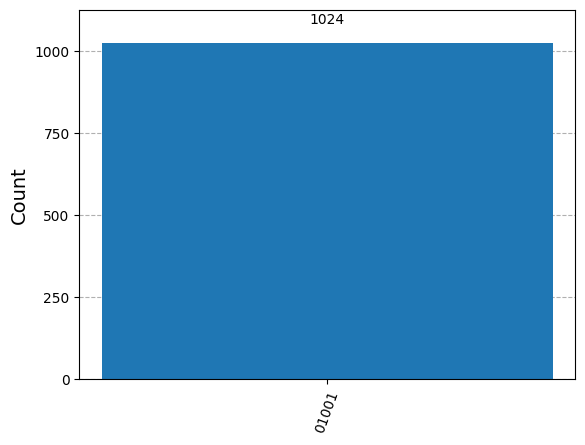

In [11]:
from qiskit.visualization import plot_histogram
import matplotlib
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [12]:
import numpy as np
from qiskit.circuit.library import QFT

In [13]:
#build the phi adder circuit
a=[0,0,1,1]
b=[0,0,1,1]
def phi_add(num_bits):
    qc = QuantumCircuit(2*num_bits,num_bits)
    #initialize a register
    for i in range(len(a)):
        if a[i] != 0: 
            qc.x(i)
    #initialize b register
    for i in range(len(b)):
        if b[i] != 0: 
            qc.x(num_bits+i)
    #append Fourier transform to second register
    qc.append(QFT(num_qubits=num_bits,do_swaps=False),range(num_bits,2*num_bits))
    #append controlled phase addition gates
    for k in range(num_bits):
        for j in range(num_bits-k):
            qc.cp(2*np.pi/2**(j+1),control_qubit=num_bits-k-1-j,target_qubit=2*num_bits-k-1)
    #append inverse Fourier transform to second register
    qc.append(QFT(num_qubits=num_bits,do_swaps=False,inverse=True),range(num_bits,2*num_bits))
    qc.measure(range(num_bits,2*num_bits), range(num_bits))
    return qc

In [14]:
phi_add(4).draw()

»
q_0: ──────────────────────────────────────────────■─────────────────■───────»
                                                   │                 │       »
q_1: ──────────────────────────────■───────────────┼────────■────────┼───────»
     ┌───┐                         │               │        │        │       »
q_2: ┤ X ├────────────────■────────┼────────■──────┼────────┼────────┼───────»
     ├───┤                │        │        │      │        │        │       »
q_3: ┤ X ├─────────■──────┼────────┼────────┼──────┼────────┼────────┼───────»
     └───┘┌──────┐ │      │        │        │      │        │        │       »
q_4: ─────┤0     ├─┼──────┼────────┼────────┼──────┼────────┼────────┼───────»
          │      │ │      │        │        │      │        │        │       »
q_5: ─────┤1     ├─┼──────┼────────┼────────┼──────┼────────┼────────┼───────»
     ┌───┐│  QFT │ │      │        │        │P(π)  │        │P(π/2)  │P(π/4) »
q_6: ┤ X ├┤2     ├─┼──────┼────────┼────────■──────┼────────■────────■───────»
     ├───┤│      │ │P(π)  │P(π/2)  │P(π/4)         │P(π/8)                   »
q_7: ┤ X ├┤3     ├─■──────■────────■───────────────■─────────────────────────»
     └───┘└──────┘                                                           »
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                 
«q_0: ────────■────────■──────────────────────────
«             │        │                          
«q_1: ─■──────┼────────┼──────────────────────────
«      │      │        │                          
«q_2: ─┼──────┼────────┼──────────────────────────
«      │      │        │                          
«q_3: ─┼──────┼────────┼──────────────────────────
«      │      │        │P(π) ┌───────┐┌─┐         
«q_4: ─┼──────┼────────■─────┤0      ├┤M├─────────
«      │P(π)  │P(π/2)        │       │└╥┘┌─┐      
«q_5: ─■──────■──────────────┤1      ├─╫─┤M├──────
«                            │  IQFT │ ║ └╥┘┌─┐   
«q_6: ───────────────────────┤2      ├─╫──╫─┤M├───
«                            │       │ ║  ║ └╥┘┌─┐
«q_7: ───────────────────────┤3      ├─╫──╫──╫─┤M├
«                            └───────┘ ║  ║  ║ └╥┘
«c: 4/═════════════════════════════════╩══╩══╩══╩═
«                                      0  1  2  3

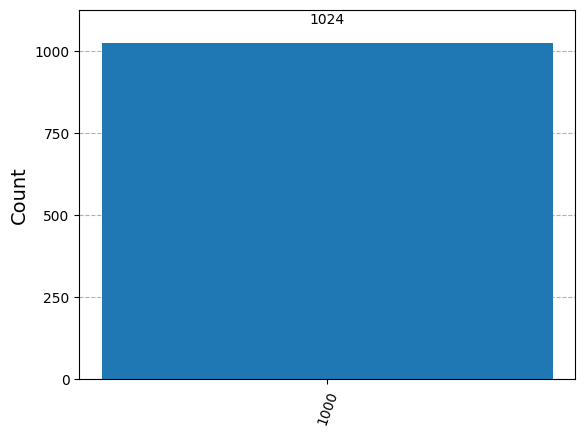

In [16]:
t_qc = transpile(phi_add(4), aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [19]:
max(counts, key=counts.get)

'1000'

In [20]:
#use built in Draper QFT adder
from qiskit.circuit.library import DraperQFTAdder

In [21]:
DraperQFTAdder(3).draw()

┌─────────────────┐
a_0: ┤0                ├
     │                 │
a_1: ┤1                ├
     │                 │
a_2: ┤2                ├
     │  DraperQFTAdder │
b_0: ┤3                ├
     │                 │
b_1: ┤4                ├
     │                 │
b_2: ┤5                ├
     └─────────────────┘

In [22]:
DraperQFTAdder(3).inverse().draw()

┌────────────────────┐
a_0: ┤0                   ├
     │                    │
a_1: ┤1                   ├
     │                    │
a_2: ┤2                   ├
     │  DraperQFTAdder_dg │
b_0: ┤3                   ├
     │                    │
b_1: ┤4                   ├
     │                    │
b_2: ┤5                   ├
     └────────────────────┘

In [23]:
qc=QuantumCircuit(6,3)
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.x(4)
qc.x(5)
qc.append(DraperQFTAdder(3),range(6))
qc.measure(range(3,6),range(3))
qc.draw()

┌───┐┌─────────────────┐         
q_0: ┤ X ├┤0                ├─────────
     ├───┤│                 │         
q_1: ┤ X ├┤1                ├─────────
     ├───┤│                 │         
q_2: ┤ X ├┤2                ├─────────
     ├───┤│  DraperQFTAdder │┌─┐      
q_3: ┤ X ├┤3                ├┤M├──────
     ├───┤│                 │└╥┘┌─┐   
q_4: ┤ X ├┤4                ├─╫─┤M├───
     ├───┤│                 │ ║ └╥┘┌─┐
q_5: ┤ X ├┤5                ├─╫──╫─┤M├
     └───┘└─────────────────┘ ║  ║ └╥┘
c: 3/═════════════════════════╩══╩══╩═
                              0  1  2

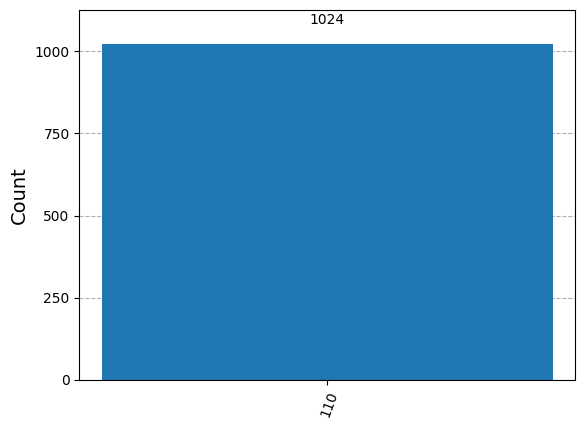

In [24]:
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [25]:
qc=QuantumCircuit(7,3)
#qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
qc.x(4)
qc.x(5)
qc.x(6)
qc.append(DraperQFTAdder(3).control(),range(7))
qc.measure(range(4,7),range(3))
qc.draw()

┌───────────────────┐         
q_0: ─────┤0                  ├─────────
     ┌───┐│                   │         
q_1: ┤ X ├┤1                  ├─────────
     ├───┤│                   │         
q_2: ┤ X ├┤2                  ├─────────
     ├───┤│                   │         
q_3: ┤ X ├┤3 c_DraperQFTAdder ├─────────
     ├───┤│                   │┌─┐      
q_4: ┤ X ├┤4                  ├┤M├──────
     ├───┤│                   │└╥┘┌─┐   
q_5: ┤ X ├┤5                  ├─╫─┤M├───
     ├───┤│                   │ ║ └╥┘┌─┐
q_6: ┤ X ├┤6                  ├─╫──╫─┤M├
     └───┘└───────────────────┘ ║  ║ └╥┘
c: 3/═══════════════════════════╩══╩══╩═
                                0  1  2

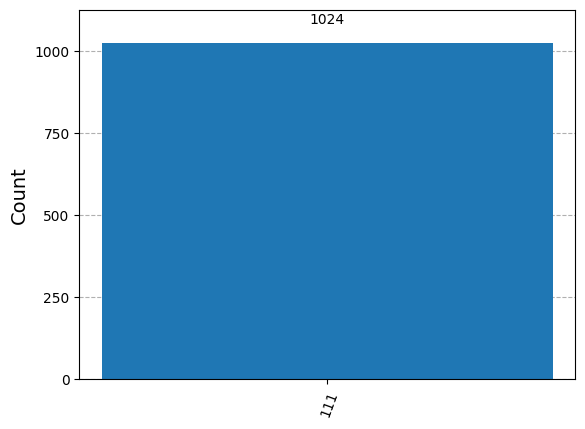

In [26]:
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)